In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!cp -r /content/drive/MyDrive/roboi_breed_classification/models /content/
!cp -r /content/drive/MyDrive/roboi_breed_classification/utils /content/

classes :  ['jump', 'rest', 'run', 'sit', 'stand', 'walk']
image : pomeranian13.jpg
sit


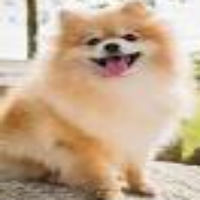

KeyboardInterrupt: ignored

In [ ]:
#!/usr/bin/env python

import torch
import numpy as np
from numpy import random

from models.experimental import attempt_load
from utils.general import non_max_suppression

import cv2 as cv
from google.colab.patches import cv2_imshow
import time
from os import listdir



def letterbox(
    img,
    new_shape=(640, 640),
    color=(114, 114, 114),
    auto=True,
    scaleFill=False,
    scaleup=True,
):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(
        img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return img, ratio, (dw, dh)


def preprocessing(img):
    img = letterbox(img, new_shape=(640, 640))[0]
    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to("cuda:0")
    img = img.half()  # if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    img = img.unsqueeze(0)
    return img



def crop_img(img,bbox):
    x1,y1,x2,y2=bbox[0],bbox[1],bbox[2],bbox[3]
    roi=img.copy()
    roi=roi[y1:y2, x1:x2]
    return roi


model_path = "/content/drive/MyDrive/roboi_breed_classification/churo.pt"

dataset_path="/content/drive/MyDrive/roboi_breed_classification/source_data/"

model = attempt_load(model_path, map_location="cuda")
model = model.autoshape()  # for autoshaping of PIL/cv2/np inputs and NMS
model.half()
names = model.module.names if hasattr(model, "module") else model.names
print("classes : ",names)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
classes={'q':'Chihuahua', 'w':'golden_retriever', 'e':'Welsh_corgi', 'r':'Pomeranian', 't':'etc'}
for img_path in listdir(dataset_path):
    print('image :',img_path)

    im0 = cv2.imread(dataset_path+img_path)

    h,w=im0.shape[:2]

    img = preprocessing(im0)
    h_,w_=640,640

    # Inference
    prediction = model(img)[0]

    prediction = non_max_suppression(prediction)
    prediction = prediction[0].cpu().numpy()

    bboxes = []
    for pred in prediction:

        if pred is not None:
            x1 = int(pred[0]/w_*w)
            y1 = int(pred[1]/h_*h)
            x2 = int(pred[2]/w_*w)
            y2 = int(pred[3]/h_*h)
            cls = int(pred[-1])
            bboxes.append([x1, y1, x2, y2, cls])
            print(names[cls])
    label=''
    for box in bboxes:
        roi = crop_img(im0,box)
        
        cv2_imshow(cv2.resize(roi, (200,200), interpolation=cv2.INTER_LINEAR))
        label=input('q :Chihuahua, w :golden_retriever, e :Welsh_corgi, r :Pomeranian, t :etc\n\n')
        
        if label==' ':
            continue
        elif label=='x':
            print('finish')
            break
        elif label in classes.keys():
            # cv2.imwrite('/content/drive/MyDrive/roboi_breed_classification/data/'+classes[cls],roi)
            print(classes[label])

        # cv.waitKey(1)
    if label=='x':
        break





In [ ]:
a=input()

a


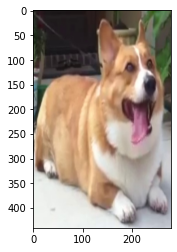

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image 

%matplotlib inline

RGB = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
imshow(RGB)